# LETTERBOXD WEB SCRAPING PROJECT - Lokeshwaran V B (002990533)
### DataFrames & Film Dreams: A Digital Love for Cinema. Just for sake of art itself.

In [1]:
# Importing all the required Libraries for Web Scraping
import bs4
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt

import requests
import re
from bs4 import BeautifulSoup

from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.common.exceptions import TimeoutException
from selenium.common.exceptions import NoSuchElementException

###  Movie Details Extraction: Functions for Scraping Movie Information from Web Pages


In [2]:
#Creating a function that extracts movie details like rating, count, synopsis, etc.....
def extract_movie_details(driver, url):
    # Navigating to the specified URL using the Selenium driver
    driver.get(url)
    
    # Initializing WebDriverWait with a timeout of 10 seconds
    wait = WebDriverWait(driver, 10)

    # Attempting to extract the movie's tagline using CSS selector; if unavailable, we will set it to None
    try:
        tagline = wait.until(EC.presence_of_element_located((By.CSS_SELECTOR, 'h4.tagline'))).text
    except TimeoutException:
        tagline = None
    
    # Attempting to extract the movie's synopsis using CSS selector; if unavailable, we will set it to None
    try:
        synopsis = wait.until(EC.presence_of_element_located((By.CSS_SELECTOR, 'div.truncate p'))).text
    except TimeoutException:
        synopsis = None

    # Attempting to extract the number of users who watched the movie on Letterboxd using CSS selector
    # Cleaning the text to get only the number; if unavailable, we will set it to None
    try:
        watched_by_text = wait.until(EC.presence_of_element_located((By.CSS_SELECTOR, 'a.icon-watched'))).get_attribute('data-original-title')
        watched_by = int(re.sub('[^0-9]', '', watched_by_text))
    except TimeoutException:
        watched_by = None
    
    # Attempting to extract the movie's average rating and the number of ratings on Letterboxd using CSS selector
    # Cleaning the text to get the numbers; if unavailable, we will set it to None
    try:
        average_rating = float(wait.until(EC.presence_of_element_located((By.CSS_SELECTOR, 'a.display-rating'))).text)
        number_of_ratings_text = wait.until(EC.presence_of_element_located((By.CSS_SELECTOR, 'a.display-rating'))).get_attribute('data-original-title').split(' ')[-1]
        number_of_ratings = int(re.sub('[^0-9]', '', number_of_ratings_text))
    except TimeoutException:
        average_rating = None
        number_of_ratings = None
    
    # Attempting to extract the movie's year of release using CSS selector; if unavailable, we will set it to None
    try:
        year = wait.until(EC.presence_of_element_located((By.CSS_SELECTOR, 'small.number a'))).text
    except TimeoutException:
        year = None

    # Parsing through the current page source with BeautifulSoup for further data extraction
    soup = BeautifulSoup(driver.page_source, 'html.parser')
    
    # Attempting to extract the director names using regex to filter href attribute; if unavailable, we will set it to None
    try:
        director_tags = soup.find_all('a', href=re.compile('/director/'))
        directors = [tag.get_text(strip=True) for tag in director_tags]
    except NoSuchElementException:
        directors = None

    # Extracting the movie's language by locating the corresponding tag; if unavailable, we will set it to None
    language_tag = soup.find('a', href=re.compile('/films/language/'), class_='text-slug')
    language = language_tag.get_text(strip=True) if language_tag else None
    
    # Attempting to extract the genre(s) names using regex to filter href attribute; if unavailable, set genre to None
    try:
        genre_tags = soup.find_all('a', href=re.compile('/films/genre/'), class_='text-slug')
        genre = [tag.get_text(strip=True) for tag in genre_tags]
    except NoSuchElementException:
        genre = None
        
    # Attempting to extract the studio(s) names using regex to filter href attribute; if unavailable, set to None
    try:
        studio_tags = soup.find_all('a', href=re.compile('/studio/'), class_='text-slug')
        studios = [tag.get_text(strip=True) for tag in studio_tags]
    except NoSuchElementException:
        studios = None
    
    # Attempting to extract the country or countries of production using regex to filter href attribute; if unavailable, set to None
    try:
        country_tags = soup.find_all('a', href=re.compile('/films/country/'), class_='text-slug')
        countries = [tag.get_text(strip=True) for tag in country_tags]
    except NoSuchElementException:
        countries = None
    
    # Attempting to locate the IMDb URL tag and navigating to the IMDb page for additional details
    imdb_url_tag = soup.find('a', {'data-track-action': 'IMDb'})
    if imdb_url_tag:
        imdb_url = imdb_url_tag.get('href')
        
        # Navigating to IMDb page using Selenium and parsing its page source with BeautifulSoup
        driver.get(imdb_url)
        imdb_soup = BeautifulSoup(driver.page_source, 'html.parser')

        # Attempting to extract IMDb Rating from the page; if unavailable, we will set it to None
        try:
            imdb_rating_tag = imdb_soup.find('span', class_='iZlgcd')
            imdb_rating = imdb_rating_tag.text.strip()
        except AttributeError:
            imdb_rating = None

        # Attempting to extract IMDb Ratings Count from the page; if unavailable, we will set it to None
        try:
            imdb_ratings_count_tag = imdb_soup.find('div', class_='bjjENQ')
            imdb_ratings_count = imdb_ratings_count_tag.text.strip()
        except AttributeError:
            imdb_ratings_count = None

        # Attempting to extract IMDb Censor Rating from the page; if unavailable, we will set it to None
        try:
            censor_rating_tag = imdb_soup.find('a', href=re.compile('/title/.+/parentalguide/certificates'))
            censor_rating = censor_rating_tag.text.strip()
        except AttributeError:
            censor_rating = None
            
        # Attempting to extract IMDb Runtime from the page; if unavailable, we will set it to None
        try:
            runtime_tag = imdb_soup.find('li', role='presentation', string=re.compile(r'\d+h \d+m'))
            runtime = runtime_tag.text.strip()
        except AttributeError:
            runtime = None
    else:
        # If IMDb URL is not available, we will set all IMDb related attributes to None
        imdb_rating = None
        imdb_ratings_count = None
        censor_rating = None
        runtime = None
        imdb_url = None
    
    # Compiling and returning the extracted movie details as a dictionary
    return {
        'Tagline': tagline,
        'Synopsis': synopsis,
        'Watched By (LetterBoxd)': watched_by,
        'Average Rating (LetterBoxd)': average_rating,
        'Number of Ratings (LetterBoxd)': number_of_ratings,
        'Year of Release': year,
        'Director': directors,
        'Studio': studios,
        'Genre': genre,
        'Language': language,
        'Country': countries,
        'Runtime': runtime,
        'IMDb Rating': imdb_rating,
        'IMDb Ratings Count': imdb_ratings_count,
        'Censor Rating': censor_rating,
        'IMDb URL': imdb_url
    }

#Main function which extracts movie names from the website and then uses the other function to extract the corresponding details. Later saves the extracted in a dictionary.
def get_movie_name_and_details(driver, soup):
    # Finding all list items containing movie data in the BeautifulSoup object
    movies_li = soup.find_all('li', class_='listitem poster-container')
    
    # Initializing a list to store dictionaries containing movie data
    movies_data = []
    
    # Iterating over each list item to extract movie name, rating, URL, and additional details
    for movie_li in movies_li:
        # Extracting movie rating from the data-average-rating attribute
        movie_rating = movie_li.get('data-average-rating')
        
        # Extracting movie name from the alt attribute of the img tag
        movie_name_tag = movie_li.find('img')
        
        # Extracting movie URL from the href attribute of the a tag
        movie_url_tag = movie_li.find('a', class_='frame')
        
        if movie_rating and movie_name_tag and movie_url_tag:
            movie_name = movie_name_tag.get('alt').strip()
            movie_url = 'https://letterboxd.com' + movie_url_tag.get('href').strip()
            
            # Extracting additional movie details using the extract_movie_details function
            movie_details = extract_movie_details(driver, movie_url)
            
            # Appending the movie data as a dictionary to the list of movies_data
            movies_data.append({
                'Movie Name': movie_name,
                'Movie URL': movie_url,
                **movie_details
            })
            
            # Printing the movie name along with its URL after extracting the details
            print(f"Scraped details for: {movie_name}")
    
    # Returning the list containing dictionaries of movie data
    return movies_data

### Web Scraping Movie Data from Letterboxd

In [3]:
# Modify options
options = Options()
# Adding various arguments to disable features and set browser options
options.add_argument("--disable-notifications")
options.add_argument("--disable-popup-blocking")
options.add_argument("--disable-infobars")
options.add_argument("--disable-extensions")
options.add_argument("--headless")
# Setting the page load strategy to eager, which means it will load the page until DOM content is loaded
options.page_load_strategy = 'eager'
# Disabling notifications
options.add_experimental_option("prefs", {"profile.default_content_setting_values.notifications": 2})
# Setting the user-agent to avoid being blocked
options.add_argument("user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36")

# Set up driver
# Initializing the Chrome WebDriver with the specified options
driver = webdriver.Chrome('chromedriver.exe', options=options)

# Set initial URL and Timeout
# Starting URL and setting the timeout duration
url = "https://letterboxd.com/films/decade/2020s"
TIMEOUT = 15

# Initialize a list to hold all movie data
all_movies_data = []

# Save the original URL for navigation purposes
original_url = url

while url:
    # Logging the current URL being scraped
    print(f"Retrieving web page URL '{url}'")
    
    # Break if we have reached page 82
    if 'page/82' in url:
        print("Reached page 82, stopping...")
        break
    
    # Navigate to the URL and wait for it to load
    driver.get(url)
    time.sleep(TIMEOUT)

    # Create a BeautifulSoup object from the page source
    soup = BeautifulSoup(driver.page_source, 'html.parser')

    # Scrape the movie data on the current page using the previously defined function
    movies_data = get_movie_name_and_details(driver, soup)
    all_movies_data.extend(movies_data)
    
    # Navigate back to the original URL (list page) for finding the next page link
    driver.get(original_url)

    # Find the link to the next page using Selenium’s WebDriverWait and expected conditions
    try:
        wait = WebDriverWait(driver, 30)  # 30 is the timeout in seconds
        next_button = wait.until(EC.presence_of_element_located((By.CSS_SELECTOR, 'div.paginate-nextprev a.next')))
        url = next_button.get_attribute('href')
        original_url = url
    except TimeoutException:
        # If no next page link is found, log a message and end the loop
        print("No next page found. Stopping.")
        url = None
            
# Close the browser window when done
driver.quit()

<ipython-input-3-b9e330babcfc>:18: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome('chromedriver.exe', options=options)


Retrieving web page URL 'https://letterboxd.com/films/decade/2020s'
Scraped details for: Everything Everywhere All at Once
Scraped details for: Barbie
Scraped details for: The Batman
Scraped details for: Spider-Man: No Way Home
Scraped details for: Oppenheimer
Scraped details for: The Menu
Scraped details for: Spider-Man: Across the Spider-Verse
Scraped details for: Dune
Scraped details for: Glass Onion
Scraped details for: Nope
Scraped details for: Don't Look Up
Scraped details for: Avatar: The Way of Water
Scraped details for: Guardians of the Galaxy Vol. 3
Scraped details for: Soul
Scraped details for: Doctor Strange in the Multiverse of Madness
Scraped details for: Top Gun: Maverick
Scraped details for: The Banshees of Inisherin
Scraped details for: Puss in Boots: The Last Wish
Scraped details for: Tenet
Scraped details for: Bullet Train
Scraped details for: X
Scraped details for: Aftersun
Scraped details for: The French Dispatch
Scraped details for: The Super Mario Bros. Movie
Scr

In [4]:
for movie in all_movies_data:
    print(f"Movie Name: {movie['Movie Name']}, "
          f"Tagline: {movie['Tagline']}, "
          f"Release Year: {movie['Year of Release']}, "
          f"Directed By: {', '.join(set(movie['Director'])) if movie['Director'] else 'N/A'}, "
          f"Genre: {', '.join(set(movie['Genre'])) if movie['Genre'] else 'N/A'}, "
          f"Studio: {', '.join(set(movie['Studio'])) if movie['Studio'] else 'N/A'}, "
          f"Language: {movie['Language']}, "
          f"Country: {', '.join(set(movie['Country'])) if movie['Country'] else 'N/A'}, "
          f"Runtime: {movie['Runtime']}, "
          f"Censor Rating: {movie['Censor Rating']}, "
          f"Average Rating (Letterboxd): {movie['Average Rating (LetterBoxd)']}, "
          f"No. of Letterboxd members who watched: {movie['Watched By (LetterBoxd)']}, "
          f"Total number of Letterboxd reviews: {movie['Number of Ratings (LetterBoxd)']}, "
          f"IMDb Rating: {movie['IMDb Rating']}, "
          f"IMDb Ratings Count: {movie['IMDb Ratings Count']}, "
          f"Synopsis: {movie['Synopsis']}, "
          f"URL (Letterboxd): {movie['Movie URL']}, "
          f"URL (IMDb): {movie['IMDb URL']}")

Movie Name: Everything Everywhere All at Once, Tagline: THE UNIVERSE IS SO MUCH BIGGER THAN YOU REALIZE., Release Year: 2022, Directed By: Daniel Scheinert, Daniel Kwan, Genre: Adventure, Action, Science Fiction, Studio: Year of the Rat Productions, A24, Ley Line Entertainment, AGBO, IAC Films, Language: English, Country: USA, Runtime: 2h 19m, Censor Rating: R, Average Rating (Letterboxd): 4.3, No. of Letterboxd members who watched: 2090560, Total number of Letterboxd reviews: 1730791, IMDb Rating: 7.8, IMDb Ratings Count: 480K, Synopsis: An aging Chinese immigrant is swept up in an insane adventure, where she alone can save what’s important to her by connecting with the lives she could have led in other universes., URL (Letterboxd): https://letterboxd.com/film/everything-everywhere-all-at-once/, URL (IMDb): http://www.imdb.com/title/tt6710474/maindetails
Movie Name: Barbie, Tagline: SHE’S EVERYTHING. HE’S JUST KEN., Release Year: 2023, Directed By: Greta Gerwig, Genre: Adventure, Come

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [5]:
#find the total number of movies scraped
print(f"Total number of movies scraped: {len(all_movies_data)}")

Total number of movies scraped: 5712


In [6]:
# Convert the list of dictionaries to a DataFrame
movies_df = pd.DataFrame(all_movies_data)
movies_df['Director'] = movies_df['Director'].apply(lambda x: ', '.join(set(x)) if isinstance(x, list) else x)
movies_df['Country'] = movies_df['Country'].apply(lambda x: ', '.join(set(x)) if isinstance(x, list) else x)
movies_df['Genre'] = movies_df['Genre'].apply(lambda x: ', '.join(set(x)) if isinstance(x, list) else x)
movies_df['Studio'] = movies_df['Studio'].apply(lambda x: ', '.join(set(x)) if isinstance(x, list) else x)

# Define the column order
column_order = [
    'Movie Name',
    'Tagline',
    'Year of Release',
    'Director',
    'Genre',
    'Studio',
    'Language',
    'Country',
    'Runtime',
    'Censor Rating',
    'Average Rating (LetterBoxd)',
    'Watched By (LetterBoxd)',
    'Number of Ratings (LetterBoxd)',
    'IMDb Rating',
    'IMDb Ratings Count',
    'Synopsis',
    'Movie URL',
    'IMDb URL'
]

# Reorder the DataFrame columns and display the DataFrame
movies_df = movies_df[column_order]
display(movies_df)

,Movie Name,Tagline,Year of Release,Director,Genre,Studio,Language,Country,Runtime,Censor Rating,Average Rating (LetterBoxd),Watched By (LetterBoxd),Number of Ratings (LetterBoxd),IMDb Rating,IMDb Ratings Count,Synopsis,Movie URL,IMDb URL
0,Everything Everywhere All at Once,THE UNIVERSE IS SO MUCH BIGGER THAN YOU REALIZE.,2022,"Daniel Scheinert, Daniel Kwan","Adventure, Action, Science Fiction","Year of the Rat Productions, A24, Ley Line Ent...",English,USA,2h 19m,R,4.3,2090560,1730791.0,7.8,480K,An aging Chinese immigrant is swept up in an i...,https://letterboxd.com/film/everything-everywh...,http://www.imdb.com/title/tt6710474/maindetails
1,Barbie,SHE’S EVERYTHING. HE’S JUST KEN.,2023,Greta Gerwig,"Adventure, Comedy, Fantasy","Heyday Films, Mattel, LuckyChap Entertainment,...",English,"UK, USA",1h 54m,PG-13,4.0,1874832,1626794.0,7.1,333K,Barbie and Ken are having the time of their li...,https://letterboxd.com/film/barbie/,http://www.imdb.com/title/tt1517268/maindetails
2,The Batman,UNMASK THE TRUTH.,2022,Matt Reeves,"Mystery, Crime, Thriller","Dylan Clark Productions, Warner Bros. Pictures...",English,USA,2h 56m,PG-13,4.0,2159342,1691595.0,7.8,733K,"In his second year of fighting crime, Batman u...",https://letterboxd.com/film/the-batman/,http://www.imdb.com/title/tt1877830/maindetails
3,Spider-Man: No Way Home,THE MULTIVERSE UNLEASHED.,2021,Jon Watts,"Adventure, Action, Science Fiction","Marvel Studios, Columbia Pictures, Pascal Pict...",English,USA,2h 28m,PG-13,3.9,2153871,1558151.0,8.2,832K,Peter Parker is unmasked and no longer able to...,https://letterboxd.com/film/spider-man-no-way-...,http://www.imdb.com/title/tt10872600/maindetails
4,Oppenheimer,THE WORLD FOREVER CHANGES.,2023,Christopher Nolan,"History, Drama","Atlas Entertainment, Syncopy, Universal Pictures",English,"UK, USA",None,R,4.3,1347144,1171674.0,8.6,445K,The story of J. Robert Oppenheimer’s role in t...,https://letterboxd.com/film/oppenheimer-2023/,http://www.imdb.com/title/tt15398776/maindetails
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5707,The Claudia Kishi Club,None,2020,Sue Ding,Documentary,,English,USA,None,None,3.6,1321,758.0,6.9,148,Asian American creatives pay passionate tribut...,https://letterboxd.com/film/the-claudia-kishi-...,http://www.imdb.com/title/tt12411586/maindetails
5708,Into the Wind,None,2022,Kristoffer Rus,"Romance, Drama","House Media Company, RE STUDIO",Polish,Poland,1h 47m,TV-MA,2.5,1577,1093.0,5.3,1.1K,,https://letterboxd.com/film/into-the-wind-2022/,http://www.imdb.com/title/tt17044594/maindetails
5709,Glasshouse,OBLIVION IS BLISS.,2021,Kelsey Egan,"Science Fiction, Thriller","Local Motion Pictures, Crave Pictures, Showmax",English,,1h 37m,None,3.2,703,545.0,5.4,717,,https://letterboxd.com/film/glasshouse-2021/,http://www.imdb.com/title/tt13724054/maindetails
5710,Gumraah,None,2023,Vardhan Ketkar,"Action, Crime, Thriller","Cine1 Studios, T-Series",Hindi,India,2h 10m,Not Rated,3.0,1428,1137.0,6.4,5K,A murder investigation becomes complicated aft...,https://letterboxd.com/film/gumraah/,http://www.imdb.com/title/tt11905536/maindetails


In [7]:
# Save the DataFrame to a CSV file
movies_df.to_csv('movies.csv', index=False)

### Analyzing the Extracted Movie Data

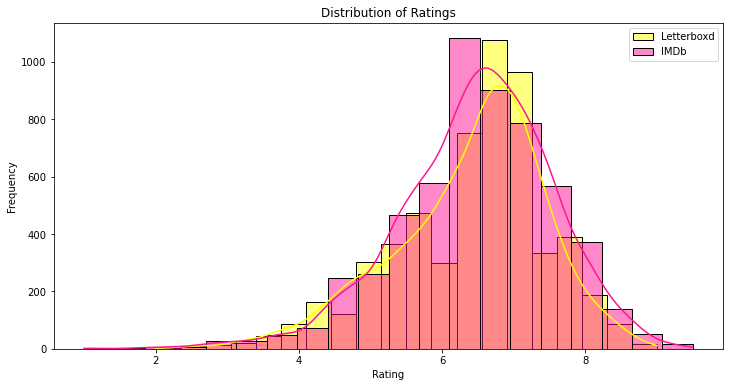

In [11]:
# Read the dataset from the CSV file
movies_df = pd.read_csv('movies.csv')

plt.figure(figsize=(12, 6))

# Adjusting the Letterboxd ratings to a 10-point scale directly within the plotting code
sns.histplot(data=movies_df, x=movies_df['Average Rating (LetterBoxd)'] * 2, kde=True, label='Letterboxd', color='#FFFF00', bins=20)

# Plotting the distribution of IMDb ratings with a pink color
sns.histplot(data=movies_df, x='IMDb Rating', kde=True, label='IMDb', color='#FF1493', bins=20)

plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.legend()
plt.show()

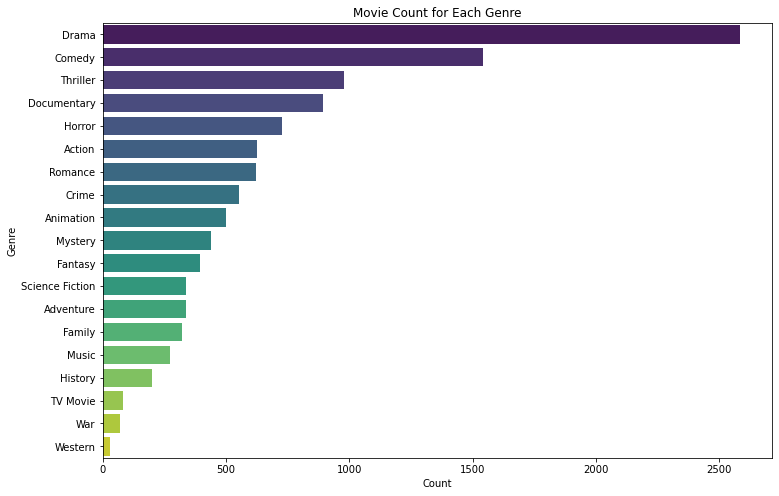

In [12]:
# Initialize an empty list to hold all genres
all_genres = []

# Iterate over the 'Genre' column, split the string, and extend the all_genres list
for genres_str in movies_df['Genre']:
    if pd.notna(genres_str):
        genres_list = genres_str.split(', ')
        all_genres.extend(genres_list)

# Convert the list of genres to a Series and count the frequency of each genre
genre_counts = pd.Series(all_genres).value_counts()

# Plotting
plt.figure(figsize=(12,8))
sns.barplot(y=genre_counts.index, x=genre_counts.values, palette='viridis')
plt.title('Movie Count for Each Genre')
plt.xlabel('Count')
plt.ylabel('Genre')
plt.show()


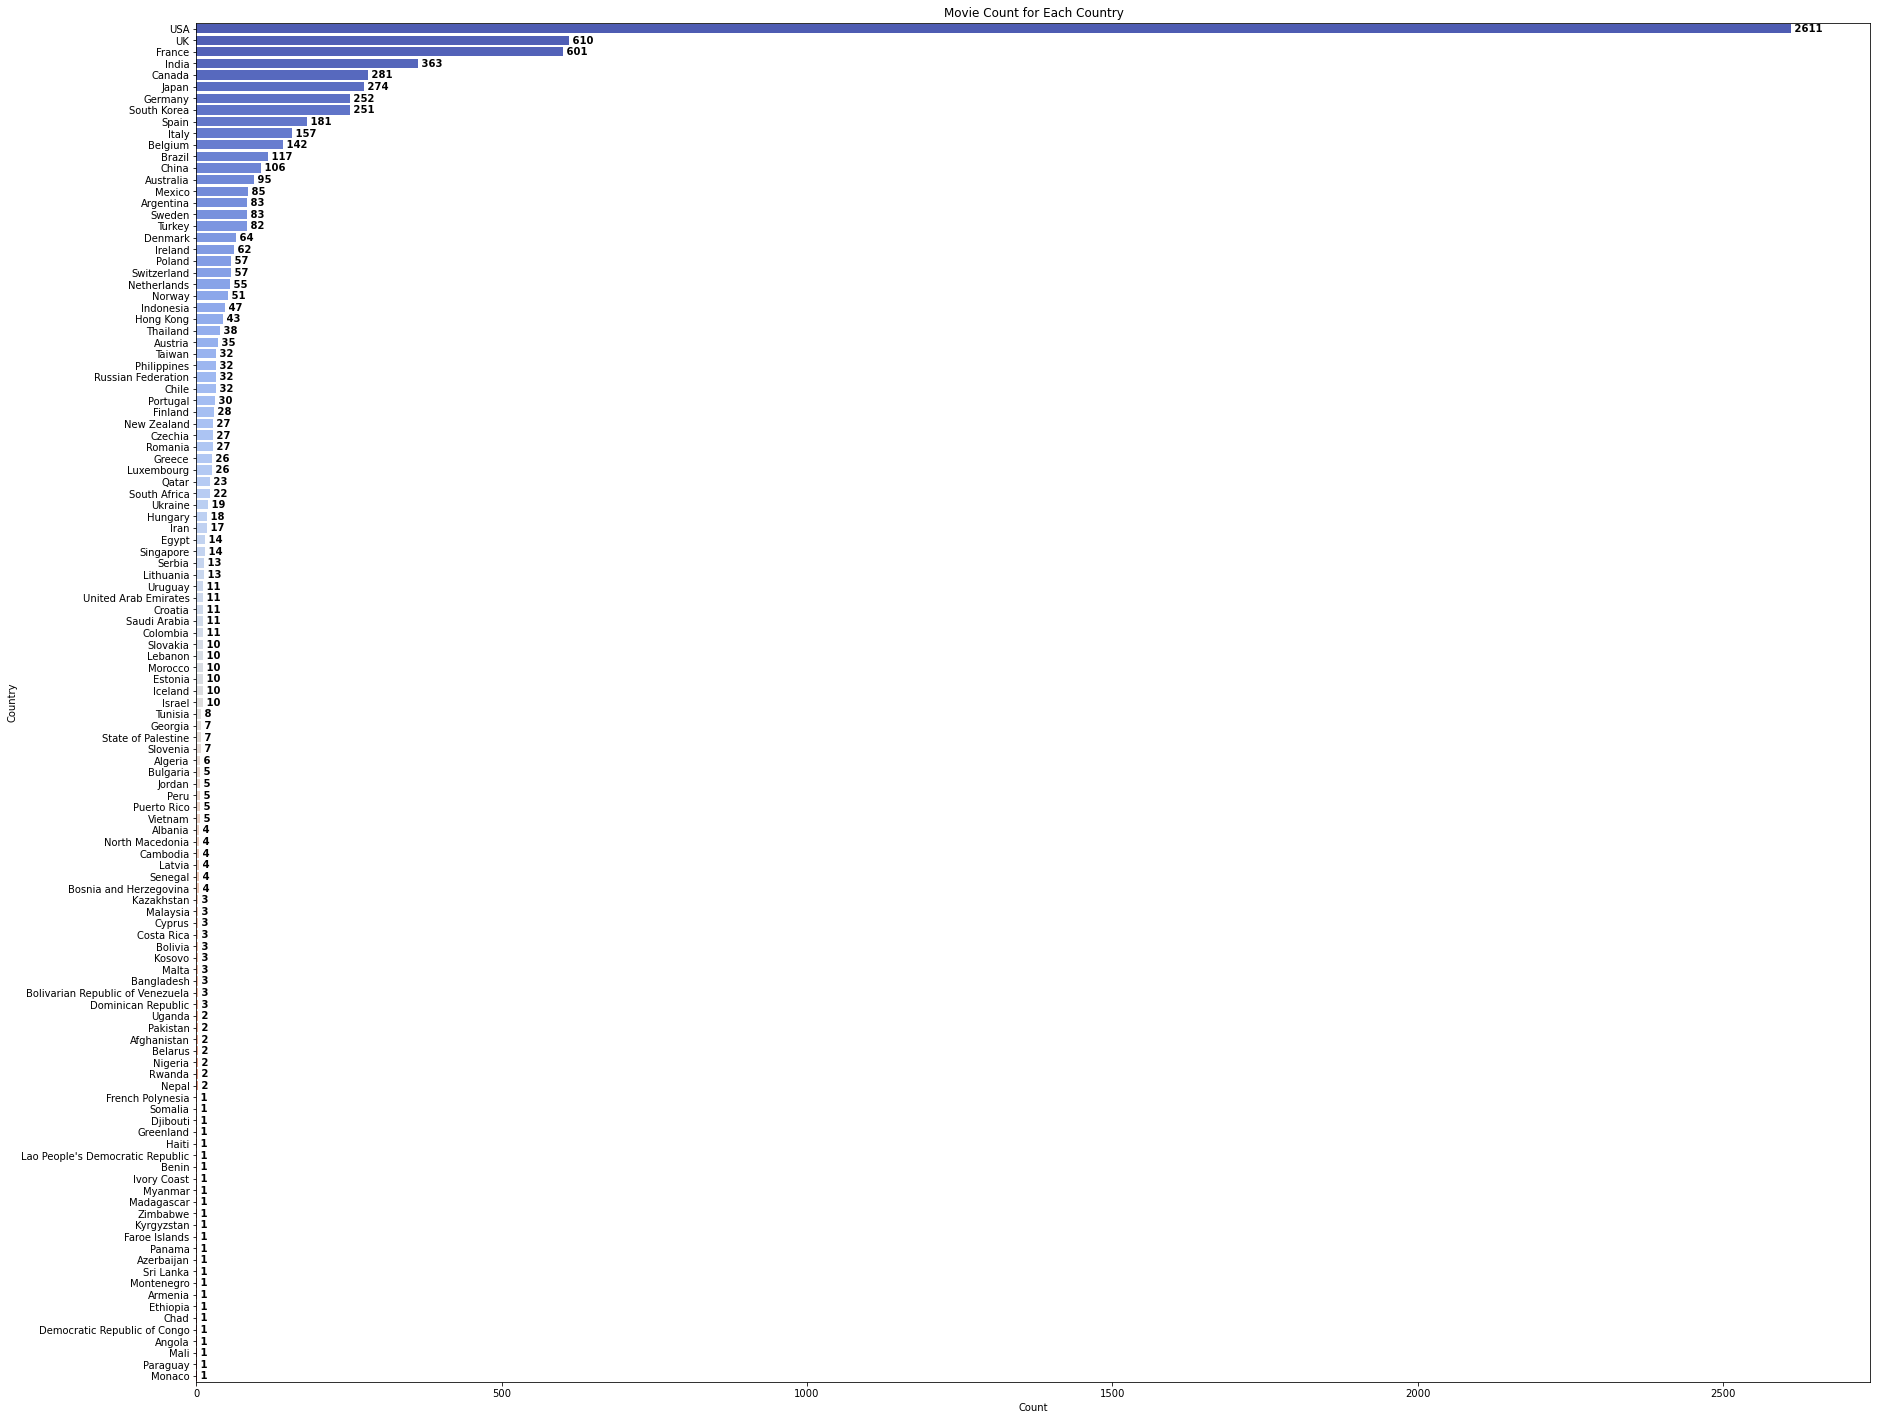

In [13]:
# Initialize an empty list to hold all countries
all_countries = []

# Iterate over the 'Country' column, split the string, and extend the all_countries list
for countries_str in movies_df['Country']:
    if pd.notna(countries_str):
        countries_list = countries_str.split(', ')
        all_countries.extend(countries_list)

# Convert the list of countries to a Series and count the frequency of each country
country_counts = pd.Series(all_countries).value_counts()

plt.figure(figsize=(30,25))

ax = sns.countplot(y=all_countries, order=country_counts.index, palette='coolwarm')
plt.title('Movie Count for Each Country')
plt.xlabel('Count')
plt.ylabel('Country')

# Annotate each bar with the count value
for i, val in enumerate(country_counts.values):
    ax.text(val, i, f' {val}', va='center', color='black', fontweight='bold')

# Show the plot
plt.show()

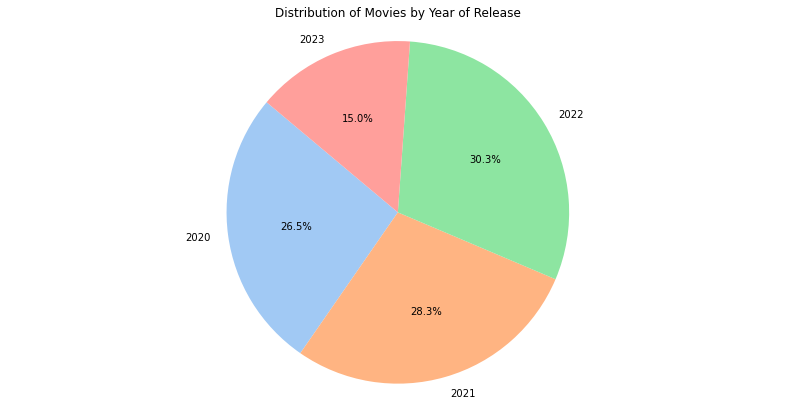

In [14]:
# Get the counts for each release year
release_year_counts = movies_df['Year of Release'].value_counts()

# Sorting index for better visualization
release_year_counts = release_year_counts.sort_index()

# Using a Seaborn color palette
colors = sns.color_palette("pastel", len(release_year_counts))

# Plotting
plt.figure(figsize=(14, 7))
plt.pie(release_year_counts, labels=release_year_counts.index, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Distribution of Movies by Year of Release')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

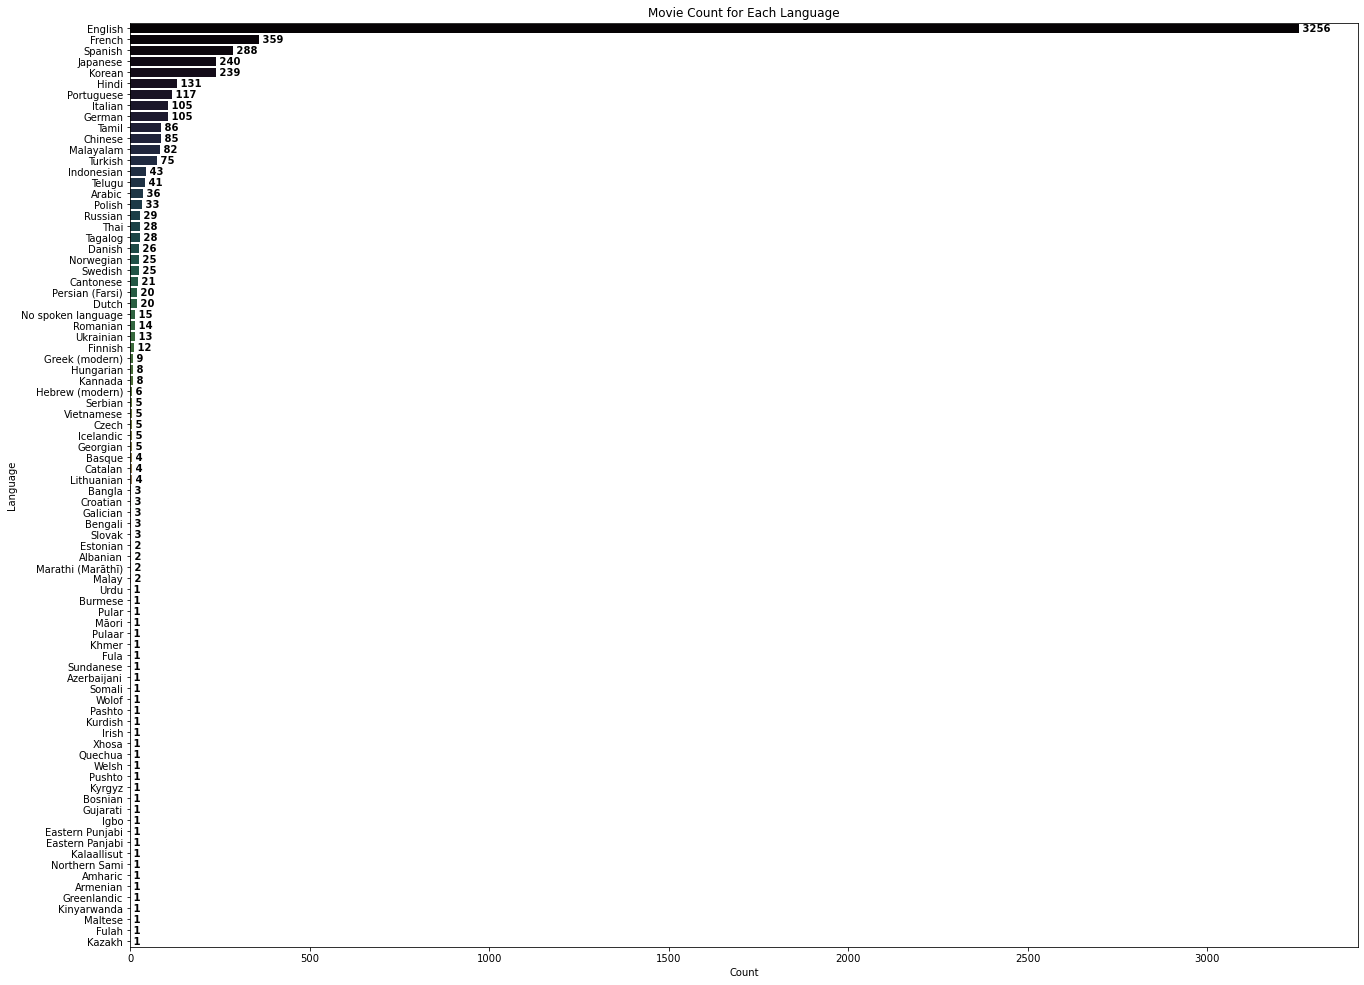

In [15]:
# Initialize an empty list to hold all languages
all_languages = []

# Iterate over the 'Language' column, split the string, and extend the all_languages list
for languages_str in movies_df['Language']:
    if pd.notna(languages_str):
        languages_list = languages_str.split(', ')
        all_languages.extend(languages_list)

# Convert the list of languages to a Series and count the frequency of each language
language_counts = pd.Series(all_languages).value_counts()

plt.figure(figsize=(22,17))

ax = sns.barplot(x=language_counts.values, y=language_counts.index, palette='cubehelix')
plt.title('Movie Count for Each Language')
plt.xlabel('Count')
plt.ylabel('Language')

# Annotate each bar with the count value
for i, val in enumerate(language_counts.values):
    ax.text(val, i, f' {val}', va='center', color='black', fontweight='bold')

# Show the plot
plt.show()